## Прогнозирование заказов такси

Необходимо обучить модель для предсказания количества заказов такси на следующий час.

## Оглавление:
* [1. Подготовка](#1)
* [2. Анализ](#2)
* [3. Обучение](#3)
* [4. Тестирование](#4)

# 1. Подготовка <a class="anchor" id="1"></a>

Импортируем библиотеки:

In [1]:
# <импорт библиотеки pandas>
import pandas as pd

# <импорт библиотеки sklearn>
import sklearn

# <Отключение предупреждений>
import warnings
warnings.filterwarnings('ignore')

# <импорт библиотеки numpy>
import numpy as np

# <импорт библиотеки matplotlib для построения графиков>
import matplotlib.pyplot as plt

Прочитаем файл с данными:

In [2]:
# <чтение файла с данными с сохранением в переменную df>
df = pd.read_csv('/datasets/taxi.csv',index_col=[0], parse_dates=[0])

Проверим расположены ли даты по порядку:

In [3]:
print(df.index.is_monotonic)

True


Осмотрим данные:

In [4]:
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB
None


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Проведем ресемплирование по одному часу и  по каждому просуммируем количество заказов.

In [5]:
df = df.resample('1H').sum()
df.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


### Вывод

Мы осмотрели данные, затем преобразовали их чтобы увидеть кол-во заказов такси за каждый час. В следующем пункте проведем анализ датасета.

# 2. Анализ <a class="anchor" id="2"></a>

Посмотрим как меняются наши данные на протяжении всего временного ряда:

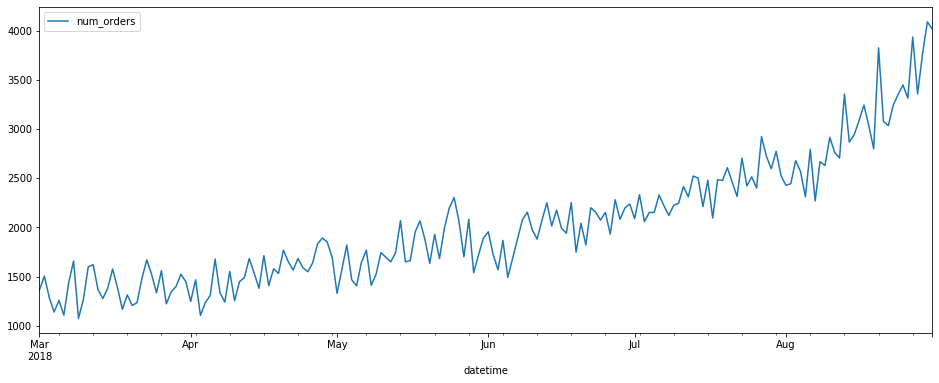

In [6]:
plt.figure(figsize=(16, 6))
df.resample('1D').sum().plot(ax=plt.gca())

Мы можем сделать вывод что наш временной ряд нестационарный - распределение и среднее значение со временем у него меняется. Такой ряд прогнозировать сложнее.

Летом гораздо больше заказов такси - люди не хотят потеть в метро, а может просто едут в аэропорты на отдых чаще)

Оценим на случайном дне как меняется количество заказов такси в течение дня.

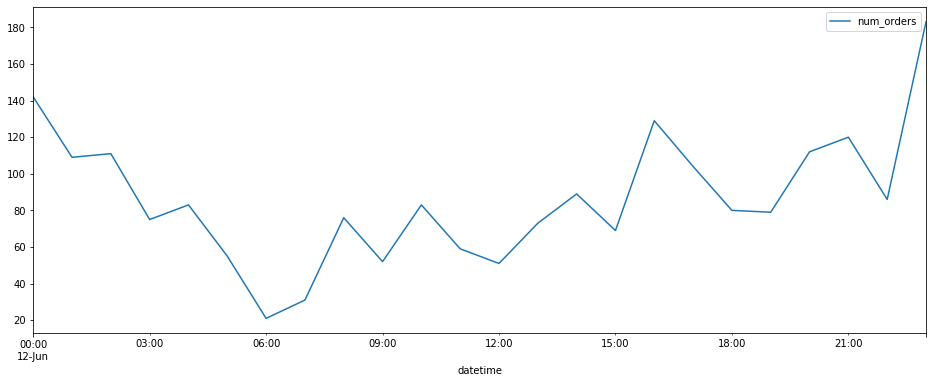

In [7]:
plt.figure(figsize=(16, 6))
df['2018-06-12 00:00:00':'2018-06-12 23:00:00'].plot(ax=plt.gca())

Очень много заказов вечером и полночь, среднее количество заказов по утрам и в течение дня. Ночью количество заказов снижается и достигает минимума в 6 утра.

Разложим временной ряд на три составляющие: тренд, сезонность и остаток. График остатка строить не будем - это шум.

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

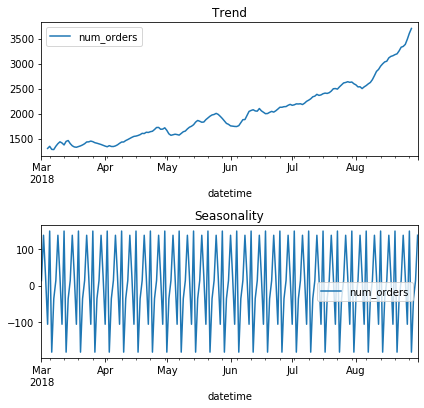

In [9]:
decomposed = seasonal_decompose(df.resample('1D').sum())

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.tight_layout()

Обнаруженный нами тренд здесь отображен. Сезонность связана с периодами меньше месяца.

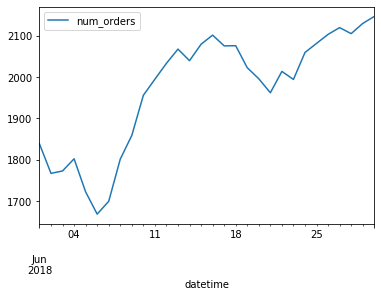

In [10]:
df.resample('1D').sum().rolling(5).mean()['2018-06-01':'2018-06-30'].plot()

Количество заказов незначительно увеличивается к концу месяца.

### Вывод

Мы проанализировали как меняются данные на протяжении всего периода, в течение месяца, дня. Осознали что временной ряд у нас нестационарен. Все это наводит на мысль что нам надо преобразовать его в разность временного ряда, а также добавить отстающие значения, календарные признаки и скользящее среднее.

# 3. Обучение <a class="anchor" id="3"></a>

Напишем функцию для создания признаков. Она будет создавать:
* Календарные признаки - год, месяц, день, день недели.
* Отстающие значения - предыдущие значения временного ряда подскажут, будет ли функция *x(t)* расти или уменьшаться.
* Скользящее среднее - скользящее среднее как признак задаст общий тренд временного ряда. 

In [7]:
def make_features(data, max_lag, rolling_mean_size,column):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data[column].shift(lag)

    data['rolling_mean'] = data[column].shift().rolling(rolling_mean_size).mean()

Сделаем временной ряд стационарным:

In [8]:
df_preproccessed = df - df.shift(fill_value=df.iloc[0,0])

Применим нашу функцию для создания признаков, по моему наблюдению чем больше лагов, тем точнее предсказание. Окно для скользящего среднего подбирал исходя из моих предположений что кол-во такси довольно различно в разные 24/6 = 4 части дня. Значит берем скользящее среднее по 6 значениям. Также пришлось сбросить *NaN* значения.

In [9]:
make_features(df_preproccessed,30,6,'num_orders')
df_preproccessed.dropna(inplace = True)

Разобьем данные на три выборки: обучающую, валидационную и тестовую. Разобьем их в отношении 8:1:1, как и было описано в задаче проекта:

In [10]:
# <Импортируем функцию из бибилиотеки sklearn>
from sklearn.model_selection import train_test_split

# <Поделим датафрейм на обучающую выборку и выборку, которую позже разделим на валидационную и тестовую.>
df_train, df_divide = train_test_split(df_preproccessed, shuffle=False, test_size=0.2, random_state=12345)

# <Поделим df_divide валидационную и тестовую выборку.>
df_valid, df_test = train_test_split(df_divide, shuffle=False, test_size=0.50, random_state=12345)

Перед исследованием моделей машинного обучения разделим наши датафреймы на целевой признак который нужно предсказать и признаки, которые помогут нам его предсказать:

In [11]:
# <Разделим обучающий датафрейм на features и target - целевой признак>
features_train = df_train.drop(['num_orders'], axis=1)
target_train = df_train['num_orders']

# <Разделим валидационный датафрейм на features и target - целевой признак>
features_valid = df_valid.drop(['num_orders'], axis=1)  
target_valid = df_valid['num_orders']

# <Разделим датафрейм для проверки модели на features и target - целевой признак>
features_test = df_test.drop(['num_orders'], axis=1)  
target_test = df_test['num_orders']

Попробуем линейную регрессию:

In [12]:
# <Импортируем метод линейной регрессии>
from sklearn.linear_model import LinearRegression

# <Импортируем среднюю квадратичную ошибку>
from sklearn.metrics import mean_squared_error

In [13]:
# <Создадим модель лин. регрессии>
model_lr = LinearRegression().fit(features_train, target_train)

# <проверим модель на валидационном датасете> 
predictions = model_lr.predict(features_valid)

# <значение метрики RMSE>
print('RMSE:','{:.3f}'.format(mean_squared_error(target_valid,predictions)**0.5))

RMSE: 34.160


Попробуем случайный лес, используем *rf* из *LightGBM*.

In [14]:
import lightgbm as lgb

Время выполнения ячейки - 2 минут 1 секунда.

In [15]:
%%time
hyper_params = {
    'task': 'train',
    'boosting_type': 'rf',
    'objective': 'regression',
    'metric': 'rmse',
    "num_iterations": 50,
    'feature_fraction': 0.2,
    'bagging_fraction': 0.3,
    'bagging_freq': 1,
    'max_bin': 122
    
}
rf = lgb.LGBMRegressor(**hyper_params)
rf.fit(features_train, target_train,
        eval_set=[(features_train, target_train)],
        eval_metric='rmse', verbose = 5)

[5]	training's rmse: 30.0764
[10]	training's rmse: 29.5388
[15]	training's rmse: 29.2626
[20]	training's rmse: 29.1622
[25]	training's rmse: 29.2959
[30]	training's rmse: 29.181
[35]	training's rmse: 29.1849
[40]	training's rmse: 29.3119
[45]	training's rmse: 29.1513
[50]	training's rmse: 29.2311
CPU times: user 622 ms, sys: 1.86 ms, total: 624 ms
Wall time: 551 ms


LGBMRegressor(bagging_fraction=0.3, bagging_freq=1, boosting_type='rf',
              class_weight=None, colsample_bytree=1.0, feature_fraction=0.2,
              importance_type='split', learning_rate=0.1, max_bin=122,
              max_depth=-1, metric='rmse', min_child_samples=20,
              min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
              n_jobs=-1, num_iterations=50, num_leaves=31,
              objective='regression', random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0, task='train')

In [58]:
# <проверим модель на валидационном датасете> 
predictions = rf.predict(features_valid)

# <значение метрики RMSE>
print('RMSE:','{:.3f}'.format(mean_squared_error(target_valid,predictions)**0.5))

RMSE: 42.836


Попробуем дерево принятия решений с градиентным бустингом (*gbdt: traditional Gradient Boosting Decision Tree*).

Время выполнения ячейки - 2 минут 4 секунды.

In [60]:
%%time
hyper_params = {
    'learning_rate': 0.1,
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    "num_iterations": 50,
}
gbdt = lgb.LGBMRegressor(**hyper_params)
gbdt.fit(features_train, target_train,
        eval_set=[(features_train, target_train)],
        eval_metric='rmse',
        early_stopping_rounds=10, verbose = 10)

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 25.764
[20]	training's rmse: 22.1099
[30]	training's rmse: 19.7771
[40]	training's rmse: 18.0172
[50]	training's rmse: 16.57
Did not meet early stopping. Best iteration is:
[50]	training's rmse: 16.57
CPU times: user 2min 4s, sys: 495 ms, total: 2min 4s
Wall time: 2min 5s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              metric='rmse', min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=100, n_jobs=-1,
              num_iterations=50, num_leaves=31, objective='regression',
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0,
              task='train')

In [61]:
# <проверим модель на валидационном датасете> 
predictions = gbdt.predict(features_valid)

# <значение метрики RMSE>
print('RMSE:','{:.3f}'.format(mean_squared_error(target_valid,predictions)**0.5))

RMSE: 36.869


Теперь попробуем *Dropouts meet Multiple Additive Regression Trees*. Мною были изменены параметры скорости обучения и значения, которое определяет какое количество признаков использовать. Это необходимо чтобы обучение прошло быстрее, так как эта модель обучается медленно.

Время выполнения ячейки - 5 минут 15 секунд.

In [72]:
%%time
hyper_params = {
    'learning_rate': 0.2,
    'task': 'train',
    'boosting_type': 'dart',
    'objective': 'regression',
    'metric': 'rmse',
    "num_iterations": 75,
    'feature_fraction': 0.2
}
dart_model = lgb.LGBMRegressor(**hyper_params)
dart_model.fit(features_train, target_train,
        eval_set=[(features_train, target_train)],
        eval_metric='rmse', verbose = 5)

[5]	training's rmse: 29.4935
[10]	training's rmse: 26.5897
[15]	training's rmse: 24.5207
[20]	training's rmse: 22.4639
[25]	training's rmse: 21.3739
[30]	training's rmse: 20.1843
[35]	training's rmse: 19.4701
[40]	training's rmse: 19.0379
[45]	training's rmse: 18.2598
[50]	training's rmse: 18.4968
[55]	training's rmse: 17.871
[60]	training's rmse: 18.1131
[65]	training's rmse: 17.9593
[70]	training's rmse: 17.3699
[75]	training's rmse: 16.9281
CPU times: user 5min 13s, sys: 1.87 s, total: 5min 15s
Wall time: 5min 18s


LGBMRegressor(boosting_type='dart', class_weight=None, colsample_bytree=1.0,
              feature_fraction=0.2, importance_type='split', learning_rate=0.2,
              max_depth=-1, metric='rmse', min_child_samples=20,
              min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
              n_jobs=-1, num_iterations=75, num_leaves=31,
              objective='regression', random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0, task='train')

In [73]:
# <проверим модель на валидационном датасете> 
predictions = dart_model.predict(features_valid)

# <значение метрики RMSE>
print('RMSE:','{:.3f}'.format(mean_squared_error(target_valid,predictions)**0.5))

RMSE: 37.133


### Вывод

Мы обучили несколько моделей с градиентным бустингом, а также линейную регрессию. В следующем пункте оценим их качество на тестовой выборке.

# 4. Тестирование <a class="anchor" id="4"></a>

Проверим наши модели на тестовой выборке.

Дерево принятия решений с градиентным бустингом:

In [62]:
predictions = gbdt.predict(features_test)
print('RMSE:','{:.3f}'.format(mean_squared_error(target_test,predictions)**0.5))

RMSE: 47.681


Случайный лес с градиентным бустингом:

In [59]:
predictions = rf.predict(features_test)
print('RMSE:','{:.3f}'.format(mean_squared_error(target_test,predictions)**0.5))

RMSE: 54.702


Линейная регрессия:

In [44]:
predictions = model_lr.predict(features_test)
print('RMSE:','{:.3f}'.format(mean_squared_error(target_test,predictions)**0.5))

RMSE: 45.311


*Dropouts meet Multiple Additive Regression Trees(DART)*:

In [74]:
predictions = dart_model.predict(features_test)
print('RMSE:','{:.3f}'.format(mean_squared_error(target_test,predictions)**0.5))

RMSE: 48.007


### Вывод

Наиболее качественной оказалась линейная регрессия. Это может быть связано с тем что деревянные модели сильно цепляются за обучающую выборку, в то время как линейная регрессия более четко выстроила веса для каждого параметра, и гораздо лучше учла засчет этого изменение данных в течение года.

Самое интересное что мною было обнаружено - увеличение кол-ва отстающих значений сильно увеличивает качество оценки. Я пробовал и 90 значений и это уменьшило RMSE еще на несколько единиц. Но решил оставить 30, чтобы проще было обучать остальные модели.